In [1]:
import sys

sys.path.append('../')

In [2]:
import os
import random
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tradercompany
from tradercompany.activation_funcs import identity, ReLU, sign, tanh
from tradercompany.binary_operators import add, diff, get_x, get_y, multiple, x_is_greater_than_y
from tradercompany.trader import Trader
from tradercompany.company import Company

%matplotlib inline


SEED = 2021
def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

fix_all_seeds(SEED)

# デモデータの作成

In [3]:
def create_dataset(T, sigma_t):
    def simulation(y_t, sigma):
        y_t1 = np.zeros(2)
        y_t1[0] = 1.0*tanh(y_t[0]) + 0.8*y_t[0]*y_t[1] + 1.0*y_t[1] - 1.0*ReLU(min(y_t[0], y_t[1])) + sigma*np.random.randn()
        y_t1[1] = +0.6*sign(y_t[1]) + 0.5*y_t[0]*y_t[1] - 1.0*max(y_t[0], y_t[1]) + sigma*np.random.randn()
        return y_t1
    
    y = np.zeros((2, T))
    y_without_noise = np.zeros((2, T))
    y[:,0] = np.array([0.1, 0.1])
    y_without_noise[:,0] = np.array([0.1, 0.1])
    
    for t in range(1, T):
        y[:,t] = simulation(y[:,t-1], sigma_t)
        y_without_noise[:,t] = simulation(y[:,t-1], 0.0)
    
    plt.plot(y[0], color = "#cc0000", label = "stock0")
    plt.plot(y[1], color = "#083090", label = "stock1")
    plt.plot(y_without_noise[0], color = "#cc0000", linestyle = "--", label = "stock0" + "(w/o noise)")
    plt.plot(y_without_noise[1], color = "#083090", linestyle = "--", label = "stock1" + "(w/o noise)")
    plt.xlabel("time", fontsize = 18)
    plt.ylabel("y", fontsize = 18)
    plt.xlim([T-100, T])
    plt.legend()
    plt.show()
    plt.close()
    
    return y, y_without_noise

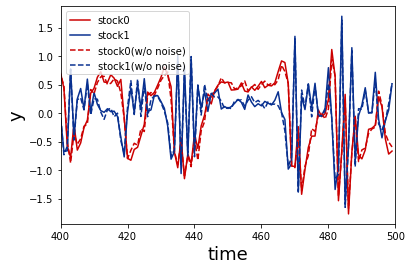

In [4]:
sigma = 0.1
T_total = 500
y, y_without_noise = create_dataset(T_total, sigma)

In [5]:
df_y = pd.DataFrame(y, index=["stock0", "stock1"]).T

In [6]:
df_y.head()

,stock0,stock1
0,0.100000,0.100000
1,0.256529,0.572601
2,0.740217,0.030293
3,0.657856,-0.086790
4,0.485371,-0.676129


# Trader-Company method

In [7]:
activation_funcs = [identity, ReLU, sign, tanh]
binary_operators = [max, min, add, diff, multiple, get_x, get_y, x_is_greater_than_y]

In [8]:
stock_names = ["stock0", "stock1"]
time_window = 200
delay_time_max = 2
num_factors_max = 4

model = Company(stock_names, 
                num_factors_max, 
                delay_time_max, 
                activation_funcs, 
                binary_operators, 
                num_traders=40, 
                Q=0.2, 
                time_window=time_window, 
                how_recruit="random")

trainとtestに分ける

In [9]:
T_train = 400
df_y_train = df_y.iloc[:T_train, :]
df_y_test = df_y.iloc[T_train:, :]

trainデータで学習 

In [10]:
model.fit(df_y_train)

100%|██████████| 397/397 [02:40<00:00,  2.48it/s] 


モデルの保存

予測する際にデータを追加していくようになっているの学習後の状態を保存しておく。  

In [11]:
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)

次の時刻の予測

In [12]:
# 時刻t+1の予測
model.aggregate()

array([ 0.5890648 , -0.07613478])

testデータに対する検証

In [20]:
with open("model.pkl", "rb") as f:
    model = pickle.load(f)

errors_test_notuning = []
for i, row in tqdm(df_y_test.iterrows()):
    prediction_test = model.aggregate()
    errors_test_notuning.append(np.abs(row.values - prediction_test))
    
    # tuning==Falseの場合、データが追加されても重みの更新などパラメータは変わらない
    model.fit_new_data(row.to_dict(), tuning=False)

100it [00:00, 129.28it/s]


In [21]:
with open("model.pkl", "rb") as f:
    model = pickle.load(f)

errors_test_tuning = []
for i, row in tqdm(df_y_test.iterrows()):
    prediction_test = model.aggregate()
    errors_test_tuning.append(np.abs(row.values - prediction_test))
    
    # tuning==Trueの場合、データが追加された際に重みの更新などパラメータが調整される
    model.fit_new_data(row.to_dict(), tuning=True)

100it [01:18,  1.28it/s]


精度の確認

In [23]:
days_ma = 5

# trader-company errors with no-tuning
errors_test_notuning = np.array(errors_test_notuning)
errors_test_notuning_ma = pd.DataFrame(errors_test_notuning).rolling(days_ma).mean()

# trader-company errors with tuning
errors_test_tuning = np.array(errors_test_tuning)
errors_test_tuning_ma = pd.DataFrame(errors_test_tuning).rolling(days_ma).mean()

# baseline method
errors_baseline = np.abs(y[:,T_train+1:] - y[:,T_train:-1])
errors_baseline_ma = pd.DataFrame(errors_baseline.T).rolling(days_ma).mean()

# lower bound
errors_lower_bound = np.abs(y[:,T_train+1:] - y_without_noise[:,T_train+1:])
errors_lower_bound_ma = pd.DataFrame(errors_lower_bound.T).rolling(days_ma).mean()

stock0


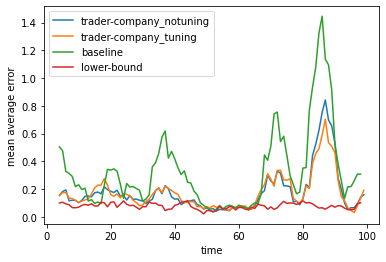

stock1


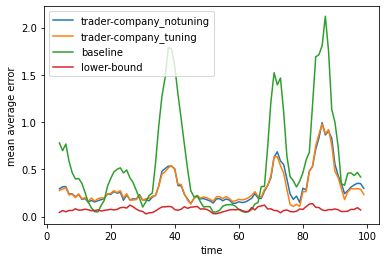

In [16]:
for i_stock, name in enumerate(stock_names):
    print(name)
    plt.plot(errors_test_notuning_ma[i_stock], label="trader-company_notuning")
    plt.plot(errors_test_tuning_ma[i_stock], label="trader-company_tuning")
    plt.plot(errors_baseline_ma[i_stock], label="baseline")
    plt.plot(errors_lower_bound_ma[i_stock], label="lower-bound")
    plt.xlabel("time")
    plt.ylabel("mean average error")
    plt.legend()
    plt.show()

In [27]:
for i_stock, name in enumerate(stock_names):
    print(name)
    print("Trader-Company notunig", errors_test_notuning.T[i_stock].mean())
    print("Trader-Company tuning", errors_test_tuning.T[i_stock].mean())
    print("baseline", errors_baseline[i_stock].mean())
    print("lower bound", errors_lower_bound[i_stock].mean())

stock0
Trader-Company notunig 0.17796931313849482
Trader-Company tuning 0.1641109902115903
baseline 0.328921920377087
lower bound 0.07759476099151122
stock1
Trader-Company notunig 0.30615631826760364
Trader-Company tuning 0.2750121441921436
baseline 0.5653867349318823
lower bound 0.07406684008048298


モデルの解釈

In [28]:
num_stock = len(stock_names)
best_trader_for = [[], []]

traders_ranking_0 = np.argsort([trader.cumulative_error[0] for trader in model.traders])
traders_ranking_1 = np.argsort([trader.cumulative_error[1] for trader in model.traders])

In [29]:
# best trader
print(stock_names[0])
print(model.traders[traders_ranking_0[0]].binary_operator[0])
print(model.traders[traders_ranking_0[0]].activation_func[1])

# best trader
print(stock_names[1])
print(model.traders[traders_ranking_1[0]].binary_operator[0])
print(model.traders[traders_ranking_1[0]].activation_func[1])

stock0
[<function add at 0x7f952c6ff310> <function add at 0x7f952c6ff310>
 <function get_y at 0x7f952c6ff550> <function get_x at 0x7f952c6ff4c0>]
[<function tanh at 0x7f952c6ff0d0> <function sign at 0x7f952c6ff160>
 <function ReLU at 0x7f952c6ff1f0> <function sign at 0x7f952c6ff160>]
stock1
[<built-in function max> <built-in function min>
 <function diff at 0x7f952c6ff3a0> <built-in function max>]
[<function tanh at 0x7f952c6ff0d0> <function ReLU at 0x7f952c6ff1f0>
 <function tanh at 0x7f952c6ff0d0>]
